In [10]:
import numpy as np
import matplotlib.pyplot as plt
import graycode
import cmath
import time
from qiskit import qpy

# Qiskit 
import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.quantum_info import Statevector

simulator = AerSimulator(method = 'statevector')    

In [13]:
''' 
This code is based on the code by Moosa et al, Quantum Sci. Technol. 9 015002.

We extend their code with new functions named as reduce_cnots and approx_thetas. 

With these functions, we can compress the original UCR-based circuit by a given compression rate.

The compression technique is based on the one in Amankwah, Scientific Reports volume 12, Article number: 7712 (2022).

'''

# UCR = Uniformly controlled Rotations
def cascade_UCRs(target_state, p, with_phases = True):
    
    r'''
    Notice that the original function by Moosa et al is modified slightly to introduce the circuit compression technique. 
    The new input parameter, p, controls the rate of circuit compression.
    
    This function returns a QuantumCircuit implementing the cascade
    of uniformly controlled rotations. This circuit can be used to 
    map an all-zero state to a target state. 
    
    Args:
        target_state (list): the state vector that we need to prepare.
        p (number): the compression rate that we choose 
        with_phases (boolean): True by default. If chosen to be False, 
            we will only get a circuit that prepares the state
            \sum_{k} |psi_k| \ket{k} instead of the full state 
            \sum_{k} \psi_{k} \ket{k}. It is especially desirable when 
            all the amplitudes are real and positive. 
    
    Returns:
        circuit (QuantumCircuit): that maps all-zero state to the
            target_state.
    
    Return type:
        Qiskit QuantumCircuit
            (https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html)
    
    Raises ValueError if: 
        the length of the target state is not 2^integer.
    '''
    
    # Determine the no. of qubits:
    no_qubits = int(np.round(np.log(len(target_state))/np.log(2)))
    if len(target_state) != 2**no_qubits:
        raise ValueError("The length of the target state should be 2^integer.")
    
    
    # Calculate the angles of rotations from the target state.
    # If the target_state is real and positive, then the angles
    # of RZ rotations are not needed.
    start_time = time.process_time()
    thetas_y = find_thetas_y(target_state)
    if p != 0:
        thetas_y = approx_thetas(thetas_y,1-p)
    duration1 = time.process_time() - start_time
    
    if with_phases:
        start_time = time.process_time()
        thetas_z, global_phase = find_thetas_z(target_state)
        if p != 0:
            thetas_z = approx_thetas(thetas_z,1-p)
        duration2 = time.process_time() - start_time
    duration = duration1 + duration2
    # Initialize the quantum circuit.
    circuit = QuantumCircuit(no_qubits)
    qubits = [k for k in range(no_qubits)]
    
    # First apply the global phase:
    if with_phases:
        circuit.rz(-global_phase,qubits[0])
    # Then apply uniformly controlled RY:
    for q in range(no_qubits):
        qs = qubits[:(q+1)]
        UCRs(circuit, 'y', thetas_y[no_qubits-1-q], qs)
    # Then apply uniformly controlled RZ:
    if with_phases:
        for q in range(no_qubits):
            qs = qubits[:(q+1)]
            UCRs(circuit, 'z', thetas_z[no_qubits-1-q], qs)
    
    return circuit, duration


def reduce_cnots(gates_list):

    '''
    This function reduces a cascade of CNOT gates whose target qubit is the same by performing a parity check

    Args:
        gates_list: a given set of gates arranged in a circuit
    
    Returns:
        reduced_gates: a list of reduced gates after removing redundant CNOTs 
    '''

    controls = np.zeros(len(gates_list))

    for j in range(len(controls)):
        controls[j] = gates_list[j][0]

    unique, counts = np.unique(controls, return_counts=True)

    reduced_gates = []
    for j in range(len(unique)):
        if counts[j] % 2 == 1:
            reduced_gates.append([unique[j],'cx'])
    
    return reduced_gates

def UCRs(circuit, axes, thetas, qubits):
    
    ''' 
    Notice that the original function by Moosa et al is modified slightly to exploit the function above, "reduced_cnots".
    
    This function implements the decompositon of a single uniformly
    controlled rotation in terms of rotation gates and CNOT gates.
    
    Args:
        circuit (QuantumCircuit in Qiskit): the circuit in which we 
            need to add a layer of uniformly controlled rotation.
        axes (str): axes for rotations. Either 'y' or 'z' are allowed.
        thetas (list): list of angles of rotations.
        qubits (list): list of qubits on which the uniformly controlled
            rotations are to be applied.
    
    Raises ValueError if: 
        axes other that 'y' or 'z' is chosen.
    '''
    qubits.reverse()
    
    gates = []
    if len(thetas)>1:
        gates.append([qubits[-1],'cx'])
    gates.append([thetas[len(thetas)-1],'rg'])
    rs = [(len(thetas)-2-r) for r in range(len(thetas)-1)]
    for r in rs:
        gates.append([qubits[cnot_position(r+1)],'cx'])
        if np.abs(thetas[r]) > 1e-08:
            gates.append([thetas[r],'rg'])

    rcount = 0
    rind = []
    for k in range(len(gates)):
        if gates[k][1] == 'rg':
            rcount += 1
            rind.append(k)

   
    reduced_gates = []
    if rcount > 0:
        if rind[0] > 1:
            reduced_gates.extend(reduce_cnots(gates[:rind[0]]))
            reduced_gates.append(gates[rind[0]])
        else:
            reduced_gates.extend(gates[:rind[0]+1])
        if rcount == 1:
            reduced_gates.extend(reduce_cnots(gates[rind[0]+1:]))

        for j in range(rcount-1):
            if rind[j+1] - rind[j] > 2:
                reduced_gates.extend(reduce_cnots(gates[rind[j]+1:rind[j+1]]))
                reduced_gates.append(gates[rind[j+1]])
            else:
                reduced_gates.extend(gates[rind[j]+1:rind[j+1]+1])
            if j == rcount - 2:
                reduced_gates.extend(reduce_cnots(gates[rind[j+1]+1:]))

    if axes == 'y':
        rot = circuit.ry
    elif axes == 'z':
        rot = circuit.rz
    else:
        raise ValueError("Only y or z axes are allowed.")
    
    for j in range(len(reduced_gates)):
        if reduced_gates[j][1] == 'cx':
            circuit.cx(int(reduced_gates[j][0]),qubits[0])
        else:
            rot(reduced_gates[j][0],qubits[0])

    return circuit

def approx_thetas(thetas, percent): 

    ''' 
    
    This function thresholds parameters called thetas by the input percentage. 
    Specifically, we set to zero the given percentage of the smallest theta values
    
    Args:
        thetas(array): parameters found using the functions involving thetas
        percent(number): the chosen compression rate
    
    Returns: 
        thresholded value(array): parameters thresholded
    '''
    
    Th = []
    for j in range(len(thetas)):
        param = thetas[j]
        for k in range(len(param)):
            Th.append(param[k])
    th = [abs(ele) for ele in Th]

    indices = np.argsort(th)
    indices = np.flip(indices)

    for j in range(len(Th)):
        if j > percent*len(Th):
            Th[indices[j]] = 0

    n = int(np.log(len(Th))/np.log(2))

    Approx_Th = []
    for j in range(n+1):
        theta_j = []
        for k in range(2**(n-j)):
            theta_j.append(Th[k + 2**(n+1) - 2**(n+1-j)])
        Approx_Th.append(theta_j)
        
    return Approx_Th
    

def find_thetas_y(target):
    
    '''
    This function finds the angles of RY rotations that appear 
    in the decomposition of the uniformly controlled rotations.
    
    Note that the angles thetas are related to angles alphas
    according to a linear map: 
        thetas = M * alphas (where M is a matrix)
    Therefore, we first find alphas and then map them to thetas.
    
    Args: 
    target (list): the state vector we need to prepare.
    
    Output: (nested list) angles of rotations.
    '''
    
    alphas_y = find_alphas_y(target)
    thetas_y = thetas_from_alphas(alphas_y)
    
    return thetas_y
    
def find_thetas_z(target):
    
    '''
    This function finds the angles of RZ rotations that appear 
    in the decomposition of the uniformly controlled rotations.
    
    Note that the angles thetas are related to angles alphas
    according to a linear map: 
        thetas = M * alphas (where M is a matrix)
    Therefore, we first find alphas and then map them to thetas.
    
    Args: 
    target (list): the state vector we need to prepare.
    
    Output: (nested list) angles of rotations.
    '''
    
    alphas_z, phase = find_alphas_z(target)
    thetas_z = thetas_from_alphas(alphas_z)
    
    return thetas_z, phase

def find_alphas_y(target):
    
    r'''
    This function find the angles of RY rotations that appear 
    in the uniformly controlled rotations.
    
    These angles can be calculated from the absolute value of
    the target state vector (psi_0, psi_1, ... , psi_{2^n - 1}):
    
    \alpha_y[j][k] = 2 \arcsin(ratio) ,
    ratio = numerator/denominator ,
    numerator = \sum_{\ell=0}^{2^{j}-1} |\psi_{(2k+1)2^{j}+\ell}|^{2} ,
    denominaor = \sum_{\ell=0}^{2^{j+1}-1} |\psi_{k 2^{j+1}+\ell}|^{2} .
    
    Args: 
    target (list): the state vector we need to prepare.
    
    Output: (nested list) angles of rotations.
    '''

    n = int(np.log(len(target))/np.log(2))

    alphas_y = []

    for j in range(n):
        alpha_j = []

        for k in range(2**(n-j-1)):

            num = 0
            for l in range(2**j):
                num = num + np.abs(target[(2*k+1)*(2**(j))+l])**2
            num = np.sqrt(num)

            den = 0
            for l in range(2**(j+1)):
                den = den + np.abs(target[k*(2**(j+1))+l])**2
            den = np.sqrt(den)

            if (den<num):
                raise ValueError("Argument of arcsin has to be less than 1.")
            elif den==num:
                ratio = 1
            else:
                ratio = num/den

            alpha_j.append(2*np.arcsin(ratio))

        alphas_y.append(alpha_j)

    return alphas_y
    
def find_alphas_z(target):
    
    '''
    This function find the angles of RZ rotations that appear 
    in the uniformly controlled rotations.
    
    These angles can be calculated from the phases of the
    target state vector (\omega_0, \omega_1, ... , \omega_{2^n - 1}):
    
    alpha_z[j][k] = 2^{-j} \sum_{\ell=0}^{2^{j}} (\omega_{(2k+1)2^{j}+\ell} - \omega_{k 2^{j+1}+\ell}) ,
    
    and
    
    global_phase = 2^{1-n} \sum_{j=0}^{2^{n}-1} \omega_{j} .
    
    Args: 
    target (list): the state vector we need to prepare.
    
    Output: (nested list) angles of rotations.
    '''

    n = int(np.log(len(target))/np.log(2))
    phases = [cmath.phase(t) for t in target]
    
    alphas_z = []

    for j in range(n):
        alpha_j = []

        for k in range(2**(n-j-1)):

            Sum = 0
            for l in range(2**j):
                Sum = Sum + (phases[(2*k+1)*(2**j)+l]-phases[(2*k)*(2**j)+l])
            Sum = Sum/(2**j)

            alpha_j.append(Sum)

        alphas_z.append(alpha_j)

    global_phase = 2*np.mean(phases)

    return alphas_z, global_phase


def thetas_from_alphas(alphas):

    '''
    This function implements the linear map M between angles alpha's
    and angles thetas:
                         thetas = M * alphas
    
    Args: 
        alphas (nested list): angles of rotation in the undecomposed 
            uniformly controlled rotations.
    
    Output:
        thetas (nested list): angles of rotation in the decomposed 
            uniformly controlled rotations.
    '''

    thetas = []

    for alpha in alphas:

        theta = []
        
        for i in range(len(alpha)):
            theta_i = 0

            for j in range(len(alpha)):
                theta_i = theta_i + M(i,j)*alpha[j]
            theta_i = theta_i/len(alpha)

            theta.append(theta_i)

        thetas.append(theta)

    return thetas

def M(i,j):

    r'''
    This function calculates the matrix elements of M = (-1)^{g_i \cdot b_j},
    where g_i abd b_i are the gray code and the binary code of the integer i
    respectively. 
    
    Args: 
        i (int): column of the matrix M
        j (int): row of the matrix M
    
    Output:
        M_ij (float): (i,j)^th matrix element of M.
    '''

    bj = bin(j)[2:]
    bj_rev = bj[::-1]
    gi = bin(graycode.tc_to_gray_code(i))[2:]
    gi_rev = gi[::-1]

    mij = 0
    for x,y in zip(bj_rev,gi_rev):
        mij = mij + int(x)*int(y)

    return (-1)**mij

def cnot_position(r):
    
    '''
    This function calculates the position of the control qubit for CNOTs 
    in a decomposed uniformly controlled rotations. 
    
    The position of the r^th CNOT (except for the last CNOT) is determined
    based on where the gray code of the interger r differs from that of
    integer r-1.  
    
    Args: 
        r (int): number of CNOT
    
    Output (integer): position of the r^th CNOT.
    '''

    g1 = bin(graycode.tc_to_gray_code(r))[2:]
    g2 = bin(graycode.tc_to_gray_code(r-1))[2:]

    if len(g2)<len(g1):
        g2 = '0' + g2

    g1_rev = g1[::-1]
    g2_rev = g2[::-1]

    for p in range(len(g1)):
        if g1_rev[p] != g2_rev[p]:
            return p+1

In [14]:
''' 
This code is a part of the code by Moosa et al, Quantum Sci. Technol. 9 015002.
It outputs truncated discrete Fourier coefficients in the form of a quantum state, enabling to simulate the FSL method.
'''

def Fourier_state(f,m):
    
    r'''
    This function calculates the (m+1)-qubit
    quantum states |c> encoding the first 2^(m+1) 
    Fourier modes of the function f.
    
    Note that the this state is defined in Eq.(1)
    of our paper.
        
    Args:
        f (list): Target state of a function 
            whose Fourier state we need to prepare.
        m (int): Determines the number of Fourier
            modes that we need to determine.
            
    Returns:
        c_state (list): Quantum state of m+1 qubits
            with 2^{m+1} dominant Fourier coefficients.
            
    Raises ValueError:
        If m is not less than total number of qubits.
    '''
    
    if len(f) < 2**(m+1):
        raise ValueError("m should be less than total number of qubits.")
    
    # Fourier Coefficients
    c = np.fft.ifft(f)

    # Fourier state:
    c_state = [*c[:2**m],0,*c[len(f)+1-2**m:]]
    c_state = c_state/np.linalg.norm(c_state)
    
    return c_state

def Fourier_state_2d(f,m):
    
    r'''
    This function calculates the 2*(m+1)-qubit
    quantum states |c> encoding the first 2^(2m+2) 
    Fourier modes of a function f of two variables.
    
    Note that the this state is defined in Eq.(C3)
    of our paper.
        
    Args:
        f (list): Target state of a 2d function 
            whose Fourier state we need to prepare.
        m (int): Determines the number of Fourier
            modes that we need to determine.
            
    Returns:
        c_state (list): Quantum state of 2*(m+1) qubits
            with 2^{2m+2} dominant Fourier coefficients.
            
    Raises ValueError:
        If m is not less than total number of qubits.
    '''
    
    N = len(f)
    if N < 2**(m+1):
        raise ValueError("m should be less than total number of qubits per dimension.")
    
    # Fourier Coefficients
    c = np.fft.ifft2(f)

    # Fourier state:
    c_state = []
    
    for k in range(2**m):
        c_state.extend([*c[k][:2**m],0,*c[k][N+1-2**m:]])
    c_state.extend(np.zeros(2**(m+1)))
    for k in range(N+1-2**m,N):
        c_state.extend([*c[k][:2**m],0,*c[k][N+1-2**m:]])
            
    c_state = c_state/np.linalg.norm(c_state)
    
    return c_state


def output_reordering(qiskit_output):
    
    '''
    The output from the Qiskit uses a different qubit
    ordering convention from the convention that we used.
    For example, Qiskit labels the state |01000> as |2>
    and |00010> as |16>. On the other hand, our convention
    demands that |2> should be a label of |00010> and |16> 
    be a label of |01000>. 
    
    This function takes an output from the Qiskit and
    returns the output which is consistent with our
    convention.
    
    Args:
        qiskit_output (list): Output from the simulation
            performed by Qiskit. 
    '''
    
    # We first determine how many qubits there are.
    # Note: dim(qiskit_output) = 2^n
    n = int(np.round(np.log(len(qiskit_output))/np.log(2)))
    
    new_output = []
    
    for k in range(len(qiskit_output)):
        
        bin_k = bin(k)[2:]
        bin_k = (n-len(bin_k))*'0' + bin_k
        bin_k_rev = bin_k[::-1]
        k_rev = int(bin_k_rev,2)
        
        new_output.append(qiskit_output[k_rev])
    
    return new_output   

In [15]:
'''
We import an image to simulate and scale it.
'''

from PIL import Image
import scipy.io
import cv2 as cv

path = 'frame_0.jpg'
image = Image.open(path)
image = np.asarray(image)

def scale(A):
    return (A-np.min(A))/(np.max(A) - np.min(A))
image = image[24:660, 218:1060, :]

In [16]:
'''
Here we zero pad the image with the respective three colors. 
'''
R_val = image[:,:,0]
r, c = R_val.shape
zero_r = int((2**10 - r)/2)
zero_c = int((2**10 - c)/2) 

R_val_new = np.pad(R_val, ((zero_r,zero_r),(zero_c,zero_c)), 'constant', constant_values=0)
G_val = image[:,:,1]
G_val_new = np.pad(G_val, ((zero_r,zero_r),(zero_c,zero_c)), 'constant', constant_values=0)
B_val = image[:,:,2]
B_val_new = np.pad(B_val, ((zero_r,zero_r),(zero_c,zero_c)), 'constant', constant_values=0)

'''
In the following, we set the truncation order of FSL method with the variable "m". 
n is the number of qubits for 2^n by 2^n image.

In our paper, we introduce two compression techniques. The following are relevant parameters.
n_block is the number of qubits for partitioned image (image partition).  
compression_rate is the value for how much we compress the UCRs of circuit (UCR compression).

'''
m = 5
n = int(np.round(np.log(len(R_val_new))/np.log(2)))
n_block = 9
compression_rate = 0.3

partition_length = 2**(n-n_block)
original_image = R_val_new
N_block = 2**n_block

In [7]:
'''
The code named "outputs" is based on the original code by Moosa et al, Quantum Sci. Technol. 9 015002.
We slightly modify their code to incorporate the UCR compression technique and check the elapsed time, a large portion of which is taken in the construction of the UCR-part of FSL circuit.
The new function "count_gates" returns the number of single-qubit gates and cnot gates used in a circuit.
'''

def outputs(image, compression_rate):

        
    n = int(np.round(np.log(len(image))/np.log(2)))
    state_c = Fourier_state_2d(image,m)

    U_c, duration = cascade_UCRs(state_c,compression_rate)
    circ = QuantumCircuit(2*n)
    Uc_qubits = [*[_ for _ in range(n-m-1,n)],*[_ for _ in range(2*n - m -1,2*n)]]
    circ.compose(U_c,qubits=Uc_qubits,inplace=True)

    for i in range(n-m-1):
        circ.cx(n-m-1,i)
        circ.cx(2*n-m-1,n+i)
    
    inv_qft = QFT(num_qubits=n, inverse=True)
    circ.compose(inv_qft,qubits=range(n-1,-1,-1),inplace=True)
    circ.compose(inv_qft,qubits=range(2*n-1,n-1,-1),inplace=True)

    output_state = Statevector(circ)
    simulated_f = output_reordering(output_state)
    simulated_f = np.array(simulated_f).reshape((2**n,2**n))
    return U_c, simulated_f, duration

def count_gates(circuit):
    cx_count = 0
    rg_count = 0

    for j in range(len(circuit)):
        if circuit[j].name == 'cx':
            cx_count += 1
        else:
            rg_count += 1
    return rg_count, cx_count

In [8]:
'''
This code implements our image encoding for the red color of an image.
It shows which partition of image is processed, the total time spent for constructing UCRs, 
and the maximal numbers of single-qubit rotation gates and cnot gates out of the corresponding image partitions.
'''
partition_length = 2**(n-n_block)
original_image = R_val_new
N_block = 2**n_block
PP_time = 0

max_RG_count = []
max_CX_count = []

for i in range(partition_length):
    for j in range(partition_length):
        print(i,j)
        image_block = original_image[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block]
        U, simulated, pp_time = outputs(image_block, compression_rate)
        RG_count, CX_count = count_gates(U)
        max_RG_count.append(RG_count)
        max_CX_count.append(CX_count)
        PP_time += pp_time
        filename = "U_r%d.qpy" % (partition_length*i+j)
        with open(filename, "wb") as file:
            qpy.dump(U, file)
        filename1 = "block_r%d.mat" % (partition_length*i+j)
        scipy.io.savemat(filename1, {'simulated': simulated})

print('Pre-processing time:',PP_time)
print('max_RG_count, max_CX_count:',np.max(max_RG_count), np.max(max_CX_count))

0 0
0 1
1 0
1 1
Pre-processing time: 104.20188266599997
max_RG_count, max_CX_count: 5740 7448


In [9]:
'''
This code is the same as above except that the input is the green color of image.
'''
partition_length = 2**(n-n_block)
original_image = G_val_new
N_block = 2**n_block
PP_time = 0

max_RG_count = []
max_CX_count = []

for i in range(partition_length):
    for j in range(partition_length):
        print(i,j)
        image_block = original_image[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block]
        U, simulated, pp_time = outputs(image_block, compression_rate)
        RG_count, CX_count = count_gates(U)
        max_RG_count.append(RG_count)
        max_CX_count.append(CX_count)
        PP_time += pp_time
        filename = "U_g%d.qpy" % (partition_length*i+j)
        with open(filename, "wb") as file:
            qpy.dump(U, file)
        filename1 = "block_g%d.mat" % (partition_length*i+j)
        scipy.io.savemat(filename1, {'simulated': simulated})

print('Pre-processing time:',PP_time)
print('max_RG_count, max_CX_count:',np.max(max_RG_count), np.max(max_CX_count))

0 0
0 1
1 0
1 1
Pre-processing time: 104.96461147800005
max_RG_count, max_CX_count: 5741 7466


In [10]:
'''
This code is the same as above except that the input is the blue color of image.
'''
partition_length = 2**(n-n_block)
original_image = B_val_new
N_block = 2**n_block
PP_time = 0

max_RG_count = []
max_CX_count = []

for i in range(partition_length):
    for j in range(partition_length):
        print(i,j)
        image_block = original_image[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block]
        U, simulated, pp_time = outputs(image_block, compression_rate)
        RG_count, CX_count = count_gates(U)
        max_RG_count.append(RG_count)
        max_CX_count.append(CX_count)
        PP_time += pp_time
        filename = "U_b%d.qpy" % (partition_length*i+j)
        with open(filename, "wb") as file:
            qpy.dump(U, file)
        filename1 = "block_b%d.mat" % (partition_length*i+j)
        scipy.io.savemat(filename1, {'simulated': simulated})

print('Pre-processing time:',PP_time)
print('max_RG_count, max_CX_count:',np.max(max_RG_count), np.max(max_CX_count))

0 0
0 1
1 0
1 1
Pre-processing time: 104.41501253900026
max_RG_count, max_CX_count: 5740 7478


In [17]:
'''
In this code and the following, we check whether the images reconstructed from our image encoding really matches the original.
Basically, we check the fidelity of the recontructed image with the original, considering the three colors.
This experiment is for the red color.
'''

Simulated_image_r = np.zeros(R_val_new.shape,  dtype= 'complex128')
fidelity = 0
count = 0
for i in range(partition_length):
    for j in range(partition_length):
        filename1 = "block_r%d.mat" % (partition_length*i+j)
        mat = scipy.io.loadmat(filename1)
        X = mat['simulated']
        Simulated_image_r[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block] += X
        Y = R_val_new[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block]
        if np.linalg.norm(X)*np.linalg.norm(Y):
            fidelity += (np.trace(np.matmul(np.conjugate(np.transpose(np.real(X))), Y)))**2/(np.linalg.norm(X)*np.linalg.norm(Y))**2
            count += 1
fidelity *= 1/count
print('Fidelity:',fidelity)



Fidelity: 0.9392180107299865


In [18]:
'''
This experiment is the same as above, except that this is for the green color.
'''

Simulated_image_g = np.zeros(R_val_new.shape,  dtype= 'complex128')
fidelity = 0
count = 0
for i in range(partition_length):
    for j in range(partition_length):
        filename1 = "block_g%d.mat" % (partition_length*i+j)
        mat = scipy.io.loadmat(filename1)
        X = mat['simulated']
        Simulated_image_g[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block] += X
        Y = G_val_new[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block]
        if np.linalg.norm(X)*np.linalg.norm(Y):
            fidelity += (np.trace(np.matmul(np.conjugate(np.transpose(np.real(X))), Y)))**2/(np.linalg.norm(X)*np.linalg.norm(Y))**2
            count += 1
fidelity *= 1/count
print('Fidelity:',fidelity)



Fidelity: 0.9296262947377594


In [19]:
'''
This experiment is the same as above, except that this is for the blue color.
'''

Simulated_image_b = np.zeros(R_val_new.shape,  dtype= 'complex128')
fidelity = 0
count = 0
for i in range(partition_length):
    for j in range(partition_length):
        filename1 = "block_b%d.mat" % (partition_length*i+j)
        mat = scipy.io.loadmat(filename1)
        X = mat['simulated']
        Simulated_image_b[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block] += X
        Y = B_val_new[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block]
        if np.linalg.norm(X)*np.linalg.norm(Y):
            fidelity += (np.trace(np.matmul(np.conjugate(np.transpose(np.real(X))), Y)))**2/(np.linalg.norm(X)*np.linalg.norm(Y))**2
            count += 1
fidelity *= 1/count
print('Fidelity:',fidelity)



Fidelity: 0.901211838340376


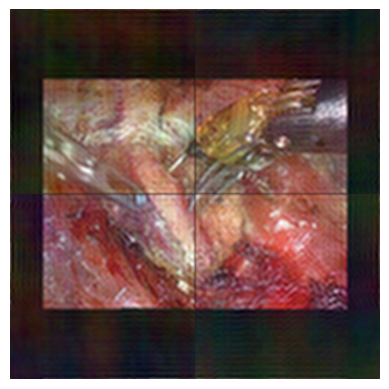

In [22]:
'''
We reconstruct the image by combining the three color channels.
'''

Resulting_image = np.zeros((2**n,2**n,3))

for i in range(partition_length):
    for j in range(partition_length):
        Resulting_image[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block,0] = scale(np.real(Simulated_image_r[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block]))
        Resulting_image[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block,1] = scale(np.real(Simulated_image_g[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block]))
        Resulting_image[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block,2] = scale(np.real(Simulated_image_b[i*N_block:(i+1)*N_block, j*N_block:(j+1)*N_block]))

plt.imshow(Resulting_image)
plt.axis('off')
plt.savefig('FAQPIE_BS_0.7.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)
